# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# The main answer of this study is: How to improve the Starbucks offer strategy?

## This work book is split into 4 main parts:
- Data cleaning
- Exploratory data analysis
- Data transformation
- Data analysis

### 1. Clean customer profile and transcript data

In [2]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [3]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [4]:
(profile.gender.isnull() & profile.income.isnull()).sum()

2175

In [5]:
profile[profile.gender.isnull()].age.unique()

array([118])

In [6]:
remove_idx=profile[profile.gender.isnull()].id

In [7]:
profile.drop(profile[profile.gender.isnull()].index, inplace=True)

In [8]:
transcript.head()
transcript = transcript[~transcript.person.isin(remove_idx)]
transcript.reset_index(inplace=True)

In [9]:
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.reset_index(inplace=True)

## 2. Exploratory data analysis
- Check the age distribution of customers
- Check the gender proportion of the customer
- Check the income distribution of the customer
- Check the income vs age distribution
- Check the offer table

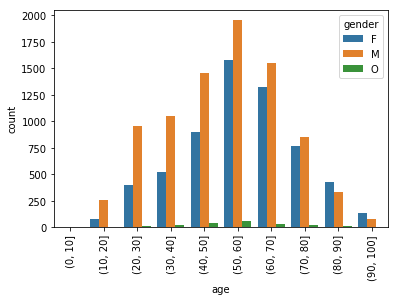

(None, 55.0, 54.393524451939292)

In [10]:
bins= [0,10,20,30,40,50,60,70,80,90,100]
x_year = pd.cut(profile.age, bins=bins)
sns.countplot(data= profile,x=x_year,hue=profile.gender)
plt.xticks(rotation=90)
plt.show(), profile.age.median(),profile.age.mean()

In [51]:
### gender proportion
profile.gender.value_counts()/profile.gender.count()

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

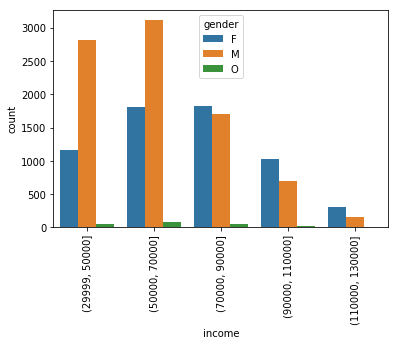

(None, 64000.0, 65404.991568296799)

In [12]:
bins = [29999,50000,70000,90000,110000,130000]
x_income = pd.cut(profile.income, bins=bins)
sns.countplot(data= profile,x=x_income,hue=profile.gender)
plt.xticks(rotation=90)
plt.show(),profile.income.median(),profile.income.mean()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

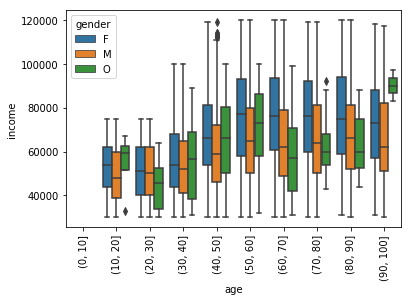

In [13]:
sns.boxplot(data= profile,x=x_year,y=profile.income,hue=profile.gender)
plt.xticks(rotation=90)


In [52]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


### Main insights from following analysis:
- Age distribution is symmetrical
- Median/average age of the customer is 55 years
- More than half of the customers are males (57.2%)
- Income distribution has right-skewed distribution
- Median/average income of the customer is 64 000/ 65 000 USD
- Females have higher median income than males across all age groups


## 3. Data transformation
- Make a reward table by transforming transcript table by unpacking value column
- Build a table which shows events per user_id
- Make a table which shows total events,awards per user_id 

In [14]:
reward_table=pd.io.json.json_normalize(transcript.value)
reward_table.head()

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
2,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
3,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


In [15]:
## Merge offer id and offer_id columns since they contain similar information 
reward_table['offer_id'].fillna(reward_table['offer id'],inplace=True)
reward_table.drop(columns='offer id',inplace=True)

In [16]:
events_per_id = transcript.groupby(by=['event','person']).value.count().unstack(level=0)
events_per_id.fillna(0,inplace=True)
events_per_id['cmplt rate'] = events_per_id['offer completed']/events_per_id['offer received']
events_per_id['view rate'] = events_per_id['offer viewed']/events_per_id['offer received']

In [17]:
events_per_id.head()

event,offer completed,offer received,offer viewed,transaction,cmplt rate,view rate
person,,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,0.60,0.8
0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,5.0,0.60,1.0
0020c2b971eb4e9188eac86d93036a77,3.0,5.0,3.0,8.0,0.60,0.6
0020ccbbb6d84e358d3414a3ff76cffd,3.0,4.0,4.0,12.0,0.75,1.0
003d66b6608740288d6cc97a6903f4f0,3.0,5.0,4.0,18.0,0.60,0.8


In [18]:
customers=pd.concat([transcript,reward_table],axis=1)
totals_per_id=pd.concat([events_per_id,customers.groupby('person')['amount','reward'].sum()],axis=1)
totals_per_id.head()

,offer completed,offer received,offer viewed,transaction,cmplt rate,view rate,amount,reward
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,0.60,0.8,127.60,9.0
0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,5.0,0.60,1.0,79.46,13.0
0020c2b971eb4e9188eac86d93036a77,3.0,5.0,3.0,8.0,0.60,0.6,196.86,14.0
0020ccbbb6d84e358d3414a3ff76cffd,3.0,4.0,4.0,12.0,0.75,1.0,154.05,13.0
003d66b6608740288d6cc97a6903f4f0,3.0,5.0,4.0,18.0,0.60,0.8,48.34,9.0


## 4. Data analysis
- How age correlates with the amount of spent money?
- How age correlates with the amount of received rewards?
- How income correlates with the amount of spent money?
- How income correlates with the ammount of received rewards?
- Which of the income and age groups spend the most money?
- Which way of communication/advertisement is the most effective?
- Which offers have the highest view/completion rate? Does it correlate with offer type, reward, difficulty or duration?
- Is there any dependence of offer completion on the customer gender,age,income ?

In [19]:
def sorting(user_info,totals_offers,param):

    df1 = user_info.set_index('id')
    
    df1 = df1[['age','gender','income']]
    
    result = pd.merge(df1,totals_offers,left_index=True,right_index=True)
    
    if param[0] == 'age':
        
        bins= [0,10,20,30,40,50,60,70,80,90,100]
        
        result['age group'] = pd.cut(result.age, bins=bins)
        
        sns.boxplot(data=result,x=result['age group'],y=param[1],hue=param[2])
        
        
    elif param[0] == 'income':
        
        bins = [29999,50000,70000,90000,110000,130000]
        
        result['income group'] = pd.cut(result.income, bins=bins)
        
        sns.boxplot(data=result,x=result['income group'],y=param[1],hue=param[2])
    

### Spent money vs age

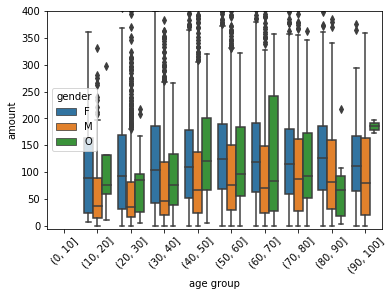

In [20]:
sorting(profile,totals_per_id,['age','amount','gender'])
plt.xticks(rotation=45)
plt.ylim(-5,400)
plt.show()


- #### In all the age groups the median value of spent money is higher for females than males.
- #### The median of spent money is in the range of 20-130 USD
- #### The most spending group is of the 50-60 age

### Rewards vs age

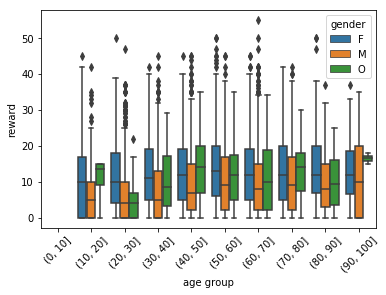

In [21]:
sorting(profile,totals_per_id,['age','reward','gender'])
plt.xticks(rotation=45)
plt.show()



- #### In all the age groups the median reward value is higher for females.
- #### Median value of rewards is in the range 5-15 USD

### Spent money vs income

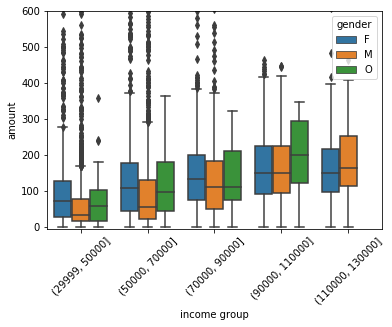

In [22]:
sorting(profile,totals_per_id,['income','amount','gender'])
plt.xticks(rotation=45)
plt.ylim(-5,600)
plt.show()


- #### Amount of money spent increases with income group
- #### Media amount of money spent is in the range of 50-150 USD

### Rewards vs income group

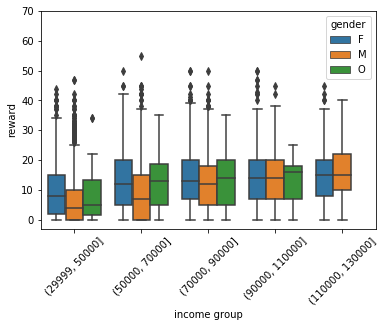

In [23]:
sorting(profile,totals_per_id,['income','reward','gender'])
plt.xticks(rotation=45)
plt.ylim(-3,70)
plt.show()

- #### Median value of rewards increases with the income group

### Which of the income and age groups spend the most ?

In [24]:
def main_stats(user_info,user_offers,param):

    df1 = user_info.set_index('id')
    
    df1 = df1[['age','gender','income']]
    
    result = pd.merge(df1,user_offers,left_index=True,right_index=True)
    
    result['age group'] = pd.cut(result.age, bins= [0,10,20,30,40,50,60,70,80,90,100])
    
    result['income group'] = pd.cut(result.income, bins= [30000,50000,70000,90000,110000,130000])
    
    if param =='age':
        
        result=result.groupby('age group')[['amount','reward']].sum()
        
        
    elif param =='income':
        
        result=result.groupby('income group')[['amount','reward']].sum()
        
    result['amount']=result['amount']/result['amount'].sum()
        
    return result['amount'].sort_values(ascending=False)
    

In [25]:
main_stats(profile,totals_per_id,'age')

age group
(50, 60]     0.263112
(60, 70]     0.211254
(40, 50]     0.151787
(70, 80]     0.121395
(30, 40]     0.093713
(20, 30]     0.068767
(80, 90]     0.059221
(90, 100]    0.015919
(10, 20]     0.014831
(0, 10]      0.000000
Name: amount, dtype: float64

- ####  More than for 40 % (~ 47 %) of Starbuck's revenue was recieved from 50-70 years old people.
- ####  Young people 10-30 years old only constitute ~8.2 % of total revenue.

In [26]:
main_stats(profile,totals_per_id,'income')

income group
(70000, 90000]      0.305566
(50000, 70000]      0.303771
(90000, 110000]     0.184412
(30000, 50000]      0.156609
(110000, 130000]    0.049642
Name: amount, dtype: float64

- #### More than 60 % of revenue was acquired from people having annual income of 50 000 - 90 0000 USD
- #### Less that 5 % of revenue came from the group with 110 000 - 130 000 USD income

 ### Which way of communication/advertisement is the most effective?

In [27]:
### make table with person id as an index and double collumn index (1st-layer offer_id, 2nd layer outcome)
offer_stats = customers.groupby(by=['person','offer_id','event']).value.count().unstack(level=[1,2])
offer_stats.head()

offer_id                         2906b810c7d4411798c6938adc9daaa5  \
event                                             offer completed   
person                                                              
0009655768c64bdeb2e877511632db8f                              1.0   
0011e0d4e6b944f998e987f904e8c1e5                              NaN   
0020c2b971eb4e9188eac86d93036a77                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                              NaN   
003d66b6608740288d6cc97a6903f4f0                              NaN   

offer_id                                         \
event                            offer received   
person                                            
0009655768c64bdeb2e877511632db8f            1.0   
0011e0d4e6b944f998e987f904e8c1e5            NaN   
0020c2b971eb4e9188eac86d93036a77            NaN   
0020ccbbb6d84e358d3414a3ff76cffd            NaN   
003d66b6608740288d6cc97a6903f4f0            NaN   

offer_id                         3f207df678b143eea3cee63160fa8bed  \
event                                              offer received   
person                                                              
0009655768c64bdeb2e877511632db8f                              1.0   
0011e0d4e6b944f998e987f904e8c1e5                              1.0   
0020c2b971eb4e9188eac86d93036a77                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                              NaN   
003d66b6608740288d6cc97a6903f4f0                              1.0   

offer_id                                       \
event                            offer viewed   
person                                          
0009655768c64bdeb2e877511632db8f          1.0   
0011e0d4e6b944f998e987f904e8c1e5          1.0   
0020c2b971eb4e9188eac86d93036a77          NaN   
0020ccbbb6d84e358d3414a3ff76cffd          NaN   
003d66b6608740288d6cc97a6903f4f0          1.0   

offer_id                         5a8bc65990b245e5a138643cd4eb9837  \
event                                              offer received   
person                                                              
0009655768c64bdeb2e877511632db8f                              1.0   
0011e0d4e6b944f998e987f904e8c1e5                              1.0   
0020c2b971eb4e9188eac86d93036a77                              1.0   
0020ccbbb6d84e358d3414a3ff76cffd                              1.0   
003d66b6608740288d6cc97a6903f4f0                              1.0   

offer_id                                       \
event                            offer viewed   
person                                          
0009655768c64bdeb2e877511632db8f          1.0   
0011e0d4e6b944f998e987f904e8c1e5          1.0   
0020c2b971eb4e9188eac86d93036a77          1.0   
0020ccbbb6d84e358d3414a3ff76cffd          1.0   
003d66b6608740288d6cc97a6903f4f0          1.0   

offer_id                         f19421c1d4aa40978ebb69ca19b0e20d  \
event                                             offer completed   
person                                                              
0009655768c64bdeb2e877511632db8f                              1.0   
0011e0d4e6b944f998e987f904e8c1e5                              NaN   
0020c2b971eb4e9188eac86d93036a77                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                              1.0   
003d66b6608740288d6cc97a6903f4f0                              NaN   

offer_id                                                      \
event                            offer received offer viewed   
person                                                         
0009655768c64bdeb2e877511632db8f            1.0          1.0   
0011e0d4e6b944f998e987f904e8c1e5            NaN          NaN   
0020c2b971eb4e9188eac86d93036a77            NaN          NaN   
0020ccbbb6d84e358d3414a3ff76cffd            1.0          1.0   
003d66b6608740288d6cc97a6903f4f0            NaN          NaN   

offer_id                         fafdcd668e3743c1bb461111dcafc2a4  \
event      

In [28]:
def portfolio_stats (prom_db,offers_db,parameter):
    
    db1 = prom_db.set_index('id')
    
    portfolio_stats = pd.DataFrame(offers_db.sum())
    
    db2 = pd.pivot_table(portfolio_stats, values=0, index=portfolio_stats.index.get_level_values(0),
                    columns=portfolio_stats.index.get_level_values(1))
    
    db2['cmplt rate']=db2['offer completed']/db2['offer received']
    
    db2['view rate']=db2['offer viewed']/db2['offer received']
    
    
    result = pd.merge(db1,db2,left_index=True,right_index=True)
    
    result['offer no'] = ([list(portfolio.id).index(i) for i in result.index])
    
    return result.sort_values(by=parameter,ascending=False)
    

In [29]:
portfolio_stats(portfolio,offer_stats,'view rate')


,channels,difficulty,duration,offer_type,reward,offer completed,offer received,offer viewed,cmplt rate,view rate,offer no
fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2,5003.0,6652.0,6407.0,0.752105,0.963169,6
4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,bogo,10,3310.0,6593.0,6329.0,0.502048,0.959958,1
f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,5,4103.0,6576.0,6310.0,0.623936,0.959550,8
2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,7,discount,3,4886.0,6655.0,6379.0,0.734185,0.958527,5
5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0,NaN,6643.0,5873.0,NaN,0.884089,7
ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10,7,bogo,10,3657.0,6683.0,5901.0,0.547209,0.882987,0
3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0,NaN,6657.0,3487.0,NaN,0.523810,2
9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,4188.0,6685.0,3499.0,0.626477,0.523411,3
2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,discount,2,3911.0,6631.0,3460.0,0.589805,0.521792,9
0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20,10,discount,5,3386.0,6726.0,2215.0,0.503420,0.329319,4


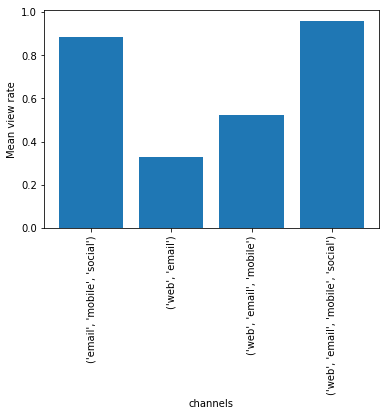

In [31]:
def stats_graph(x, view_param, mean=True):
    
    db = portfolio_stats(portfolio,offer_stats,['offer completed','difficulty'])
    
    if x == 'channels':
        if mean:
            result = db.groupby(db[x].map(tuple)).mean()

            plt.bar([str(i) for i in result.index],result[view_param])

            plt.xticks(rotation=90)

            plt.ylabel('Mean ' + view_param)
            
            plt.xlabel(x)

            plt.plot()
            
        else:
            result = db.groupby(db[x].map(tuple)).median()

            plt.bar([str(i) for i in result.index],result[view_param])

            plt.xticks(rotation=90)

            plt.ylabel('Median ' + view_param)
            
            plt.xlabel(x)

            plt.plot()

    else:
        
        if mean:
            result = db.groupby(db[x]).mean()

            plt.bar([str(i) for i in result.index],result[view_param])

            plt.xticks(rotation=90)

            plt.ylabel('Mean ' + view_param)
            
            plt.xlabel(x)

            plt.plot()
        else:
            result = db.groupby(db[x]).median()

            plt.bar([str(i) for i in result.index],result[view_param])

            plt.xticks(rotation=90)

            plt.ylabel('Median ' + view_param)
            
            plt.xlabel(x)

            plt.plot()

        
    
stats_graph('channels','view rate',True)   

 - #### Promotions dissemenitated through web, email and mobile only reaced every second targeted customer.
 - #### View rate increases above 80% when social channel is used

### Which offers were sent to customer the most times?

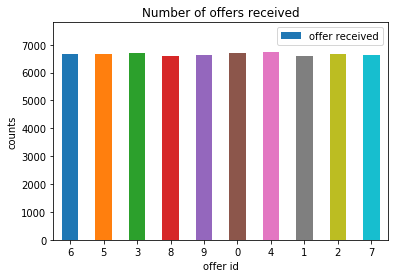

In [38]:
portfolio_stats(portfolio,offer_stats,'cmplt rate').plot.bar(x='offer no',y='offer received')
plt.xlabel('offer id')
plt.xticks(rotation=0)
plt.ylim(0,7800)
plt.ylabel('counts')
plt.title('Number of offers received')
plt.show()

In [46]:
portfolio_stats(portfolio,offer_stats,'offer received')[['offer no','offer received']]

,offer no,offer received
0b1e1539f2cc45b7b9fa7c272da2e1d7,4,6726.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,3,6685.0
ae264e3637204a6fb9bb56bc8210ddfd,0,6683.0
3f207df678b143eea3cee63160fa8bed,2,6657.0
2298d6c36e964ae4a3e7e9706d1fb8c2,5,6655.0
fafdcd668e3743c1bb461111dcafc2a4,6,6652.0
5a8bc65990b245e5a138643cd4eb9837,7,6643.0
2906b810c7d4411798c6938adc9daaa5,9,6631.0
4d5c57ea9a6940dd891ad53e9dbe8da0,1,6593.0
f19421c1d4aa40978ebb69ca19b0e20d,8,6576.0


- #### There is no sigficant difference in the number of sent offers 

### What is distirbution of completion rate between offers?

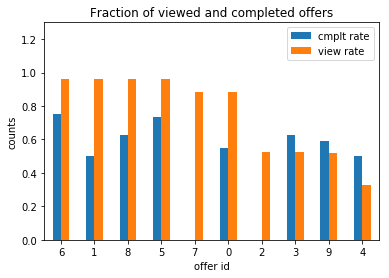

In [50]:
portfolio_stats(portfolio,offer_stats,'view rate').plot.bar(x='offer no',y=['cmplt rate','view rate'])
plt.xlabel('offer id')
plt.xticks(rotation=0)
plt.ylim(0,1.3)
plt.ylabel('counts')
plt.title('Fraction of viewed and completed offers')
plt.show()

### Which offers have the highest view/completion rate? Does it correlate with offer type, reward, difficulty or duration?

### Offer type

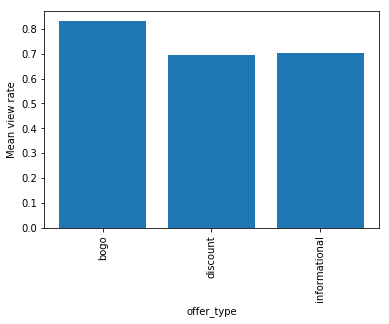

In [31]:
stats_graph('offer_type','view rate')

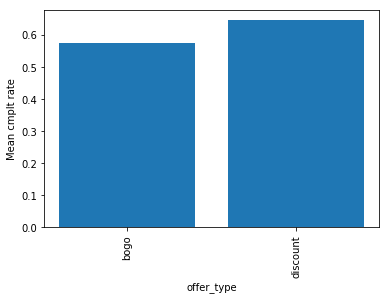

In [32]:
stats_graph('offer_type','cmplt rate')

- #### Bogo type offers are the most viewed (rate > 80 %), whereas discount and informational have ~70% view rate.
- #### Completion is higher for discount type offers (> 60%), while slightly below 60 % of bogo offers are completed.

### Reward

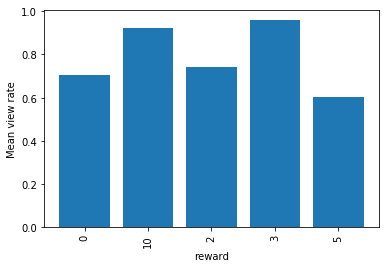

In [33]:
stats_graph('reward','view rate')

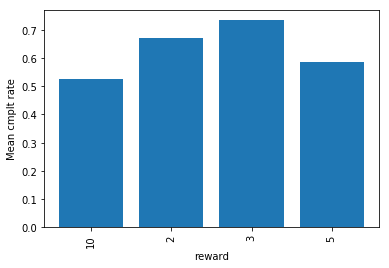

In [34]:
stats_graph('reward','cmplt rate')

- #### There is no clear correlation between reward and view rate.
- #### Completion rate is higher for 2-3 USD rewards (> 65 %) than for 5-10 USD rewards (< 60 %). 

### Difficulty

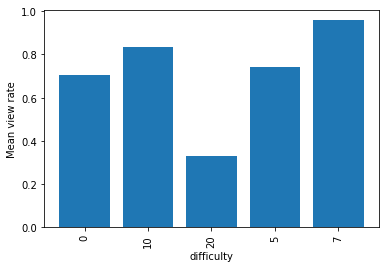

In [35]:
stats_graph('difficulty','view rate')

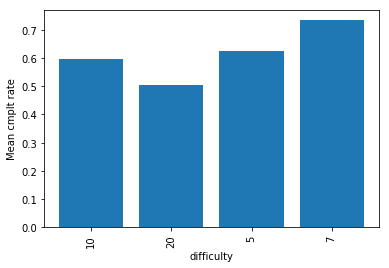

In [36]:
stats_graph('difficulty','cmplt rate')

- #### View rate is the lowest for the most difficult offer (20 USD), while the remaining ones the view rate is at least twice as big (~60 %)
- #### Completion rate varies from ~50% (20 USD difficulty) to ~70% (7 USD difficulty) 

### Duration

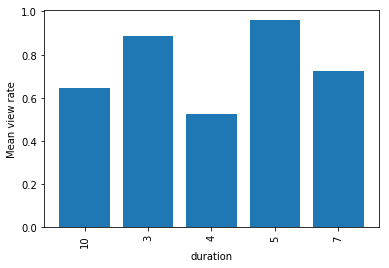

In [37]:
stats_graph('duration','view rate')

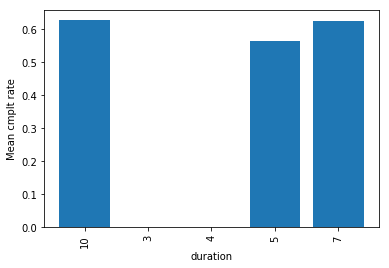

In [38]:
stats_graph('duration','cmplt rate')

- #### View rare does not depend on the offer duration, since the highest view rate is recorded for 3 and 5 day offers
- #### Completion rate does not strongly depend on the duration of the offer.

### Is there any dependence of offer completion on the customer gender,age,income ?

In [76]:
### Shortening the names of columns 
new_columns=[]
for i in offer_stats.columns:
    x=list(i)
    x[0]=(list(portfolio.id).index(i[0]))
    if x[1] == 'offer completed': x[1]='cmpl'
    elif x[1] == 'offer received': x[1]='recv'
    elif x[1] == 'offer viewed': x[1]='view'    
    new_columns.append(tuple(x))   
offer_stats.columns=new_columns
offer_stats= offer_stats.reindex(sorted(offer_stats.columns), axis=1)

In [77]:
def customer_profile_stats (db1,db2,offer,param,gender):
    ## prepare first table for merge
    
    customers = db1.set_index('id')
    customers = customers[['age','gender','income']]
    customers['age'] = pd.cut(customers.age, bins=[10,20,30,40,50,60,70,80,90,100,110])
    customers['income']=pd.cut(customers.income, bins = [29999,50000,70000,90000,110000,130000])
    
    ## merge two tables
    
    result=pd.merge(customers,db2,left_index=True,right_index=True)
    
    ## select gender
    
    result = result[result.gender == gender]
    
    ## group by selected parameter
    
    result = result.groupby(by=param).sum()
        
        
    ## select the offer 
    
    off_filter = []
    
    for i in result.columns:
        
        if i[0] == offer:
            off_filter.append(i)
            
    off_filter.sort()
    
    result=result[off_filter]
        
    return result.div(result[(offer,'recv')],axis=0)*100

    

### Female: age vs completion/view rate

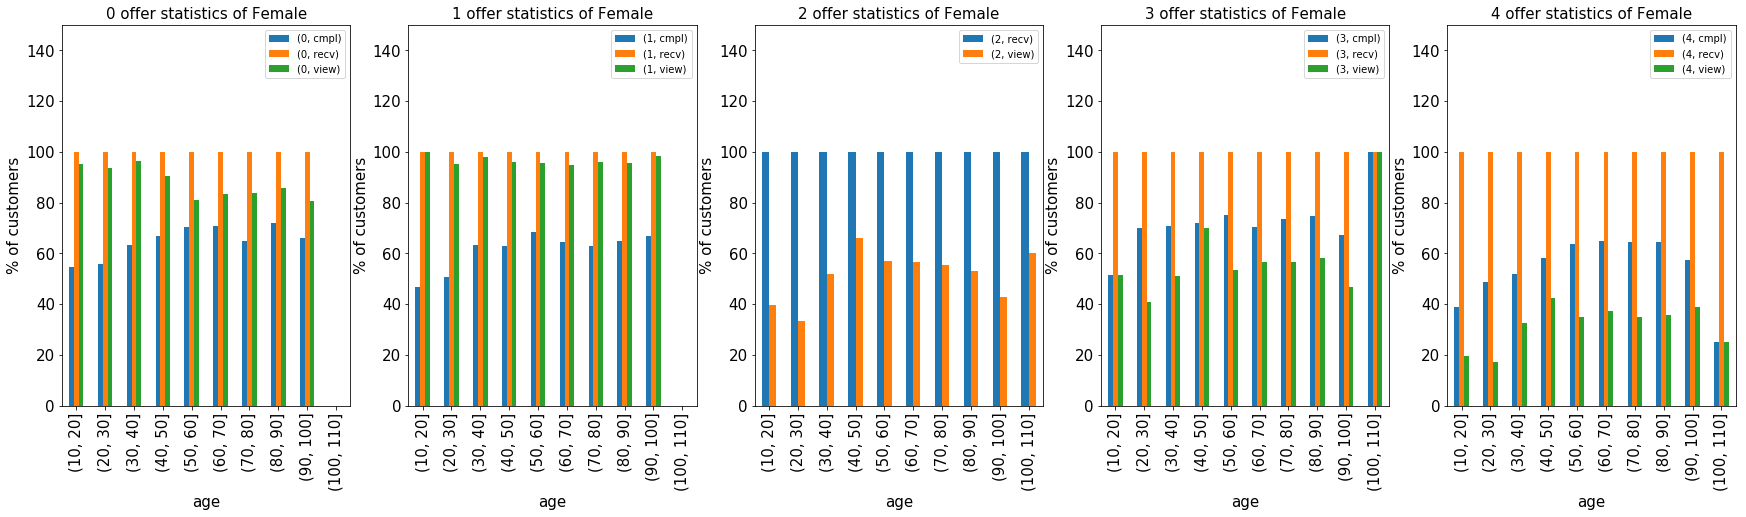

In [78]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i)+' offer statistics of Female',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i,['age'],'F').plot.bar(rot=90,ax=ax)


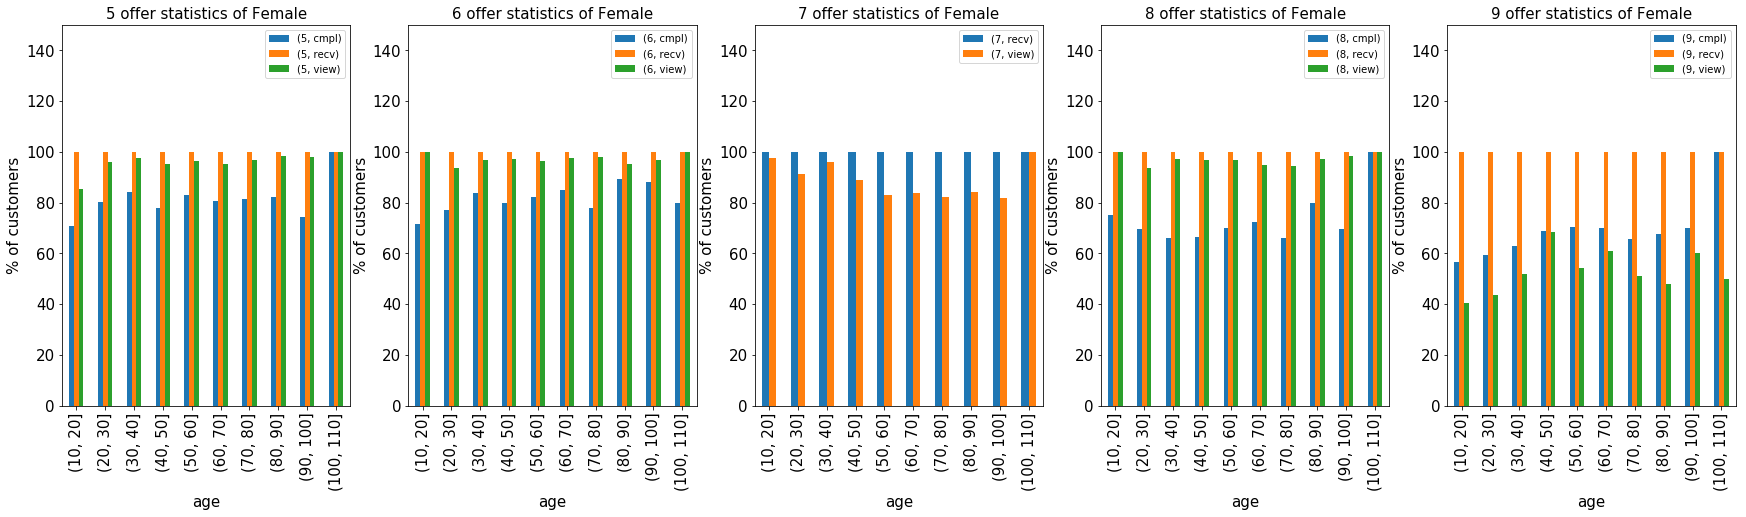

In [79]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i+5)+' offer statistics of Female',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i+5,['age'],'F').plot.bar(rot=90,ax=ax)


### Male: age vs completion/view rate

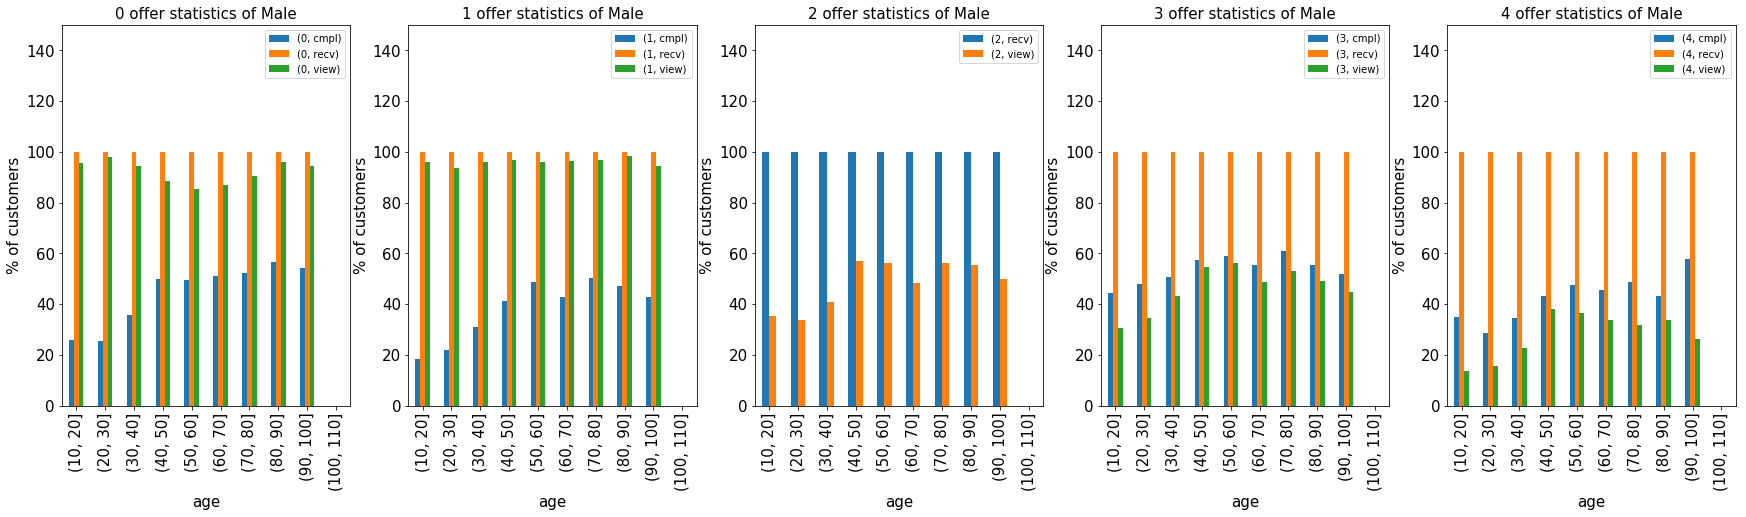

In [80]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i)+' offer statistics of Male',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i,['age'],'M').plot.bar(rot=90,ax=ax)


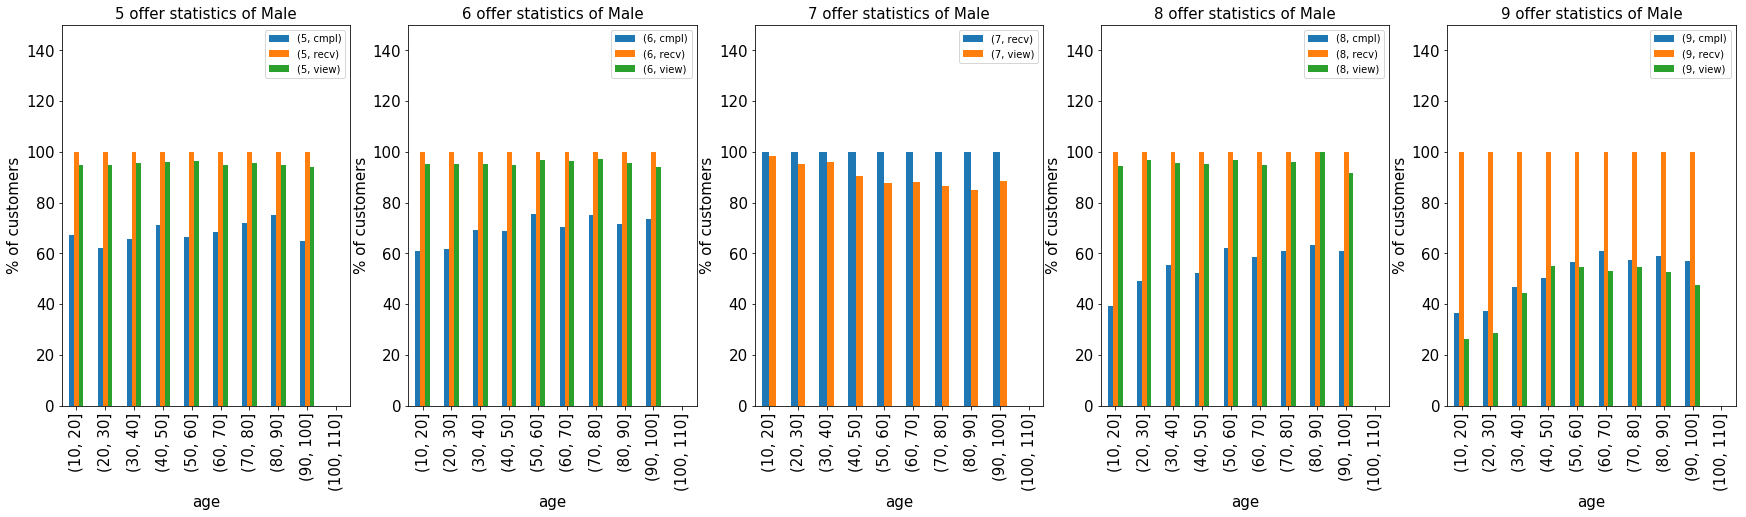

In [81]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i+5)+' offer statistics of Male',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i+5,['age'],'M').plot.bar(rot=90,ax=ax)


### Female: income vs completion/view rate

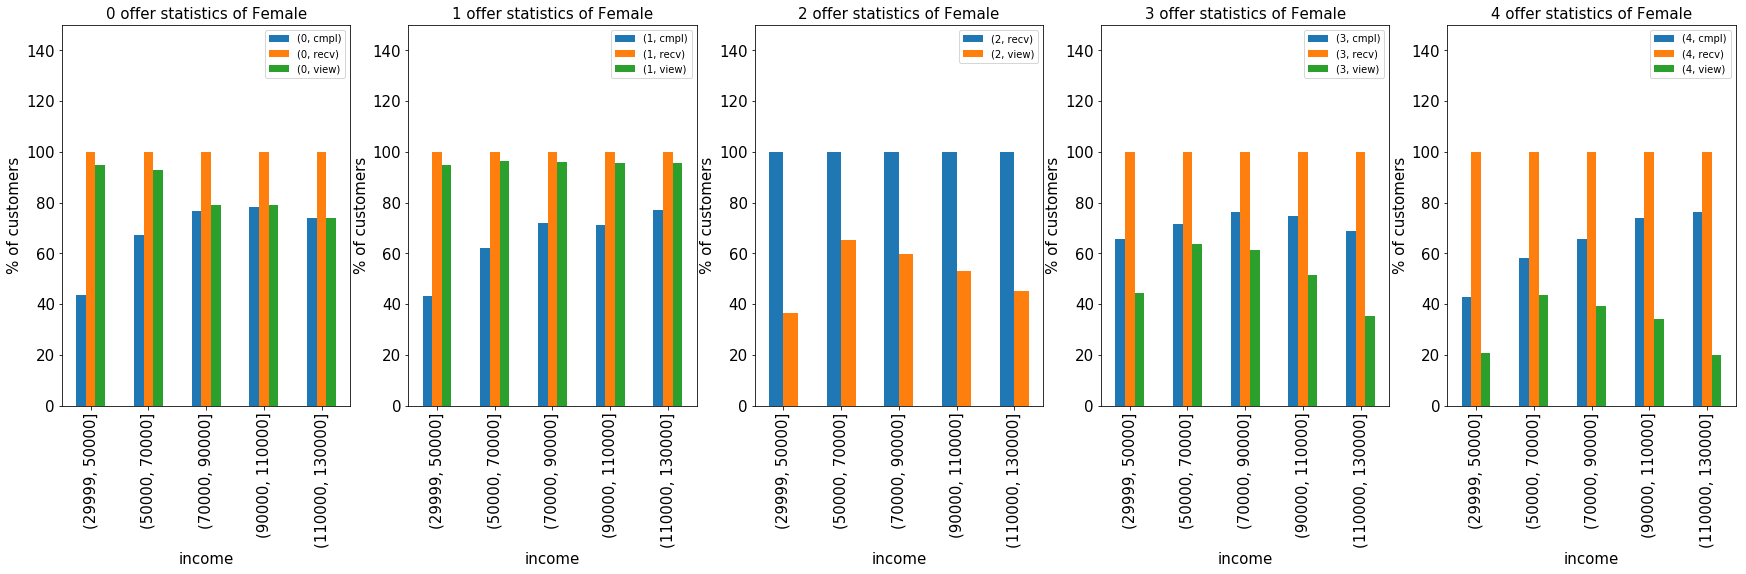

In [82]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i)+' offer statistics of Female',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i,['income'],'F').plot.bar(rot=90,ax=ax)


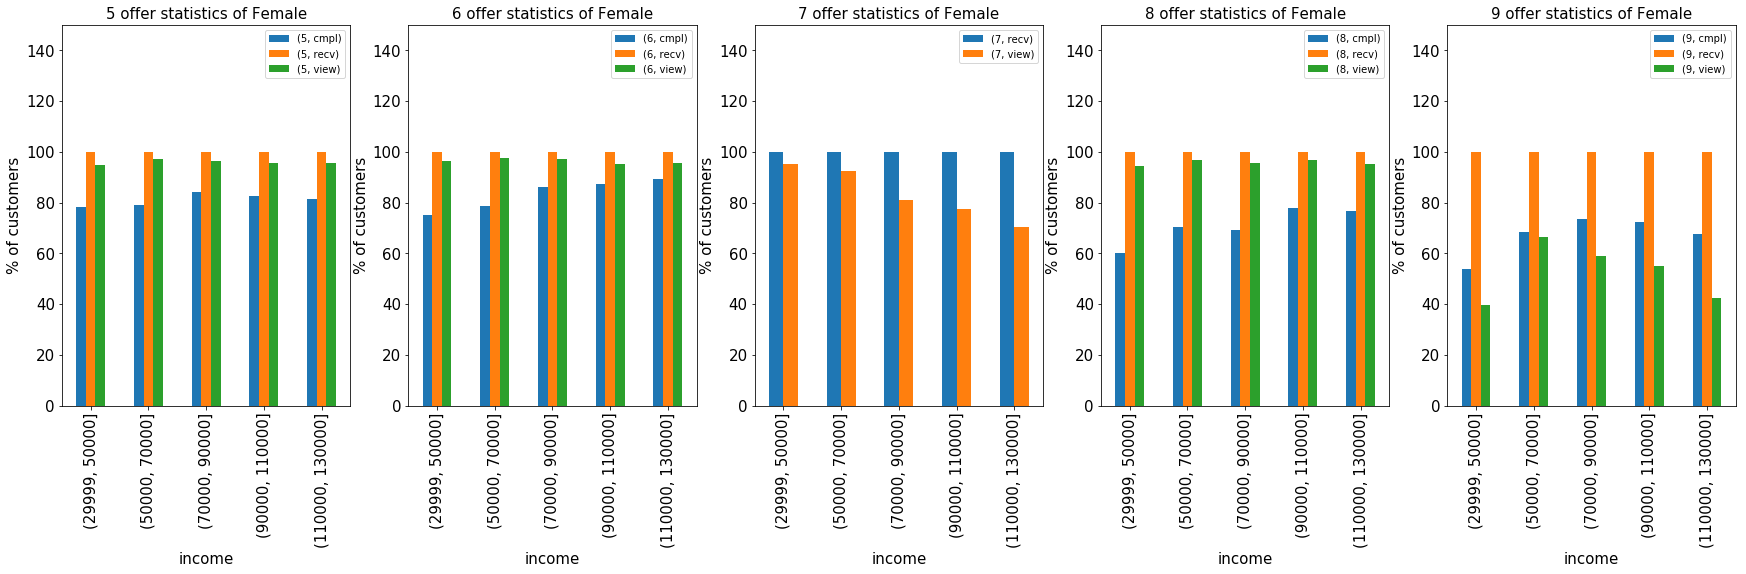

In [84]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i+5)+' offer statistics of Female',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i+5,['income'],'F').plot.bar(rot=90,ax=ax)


### Male: income vs completion/view rate

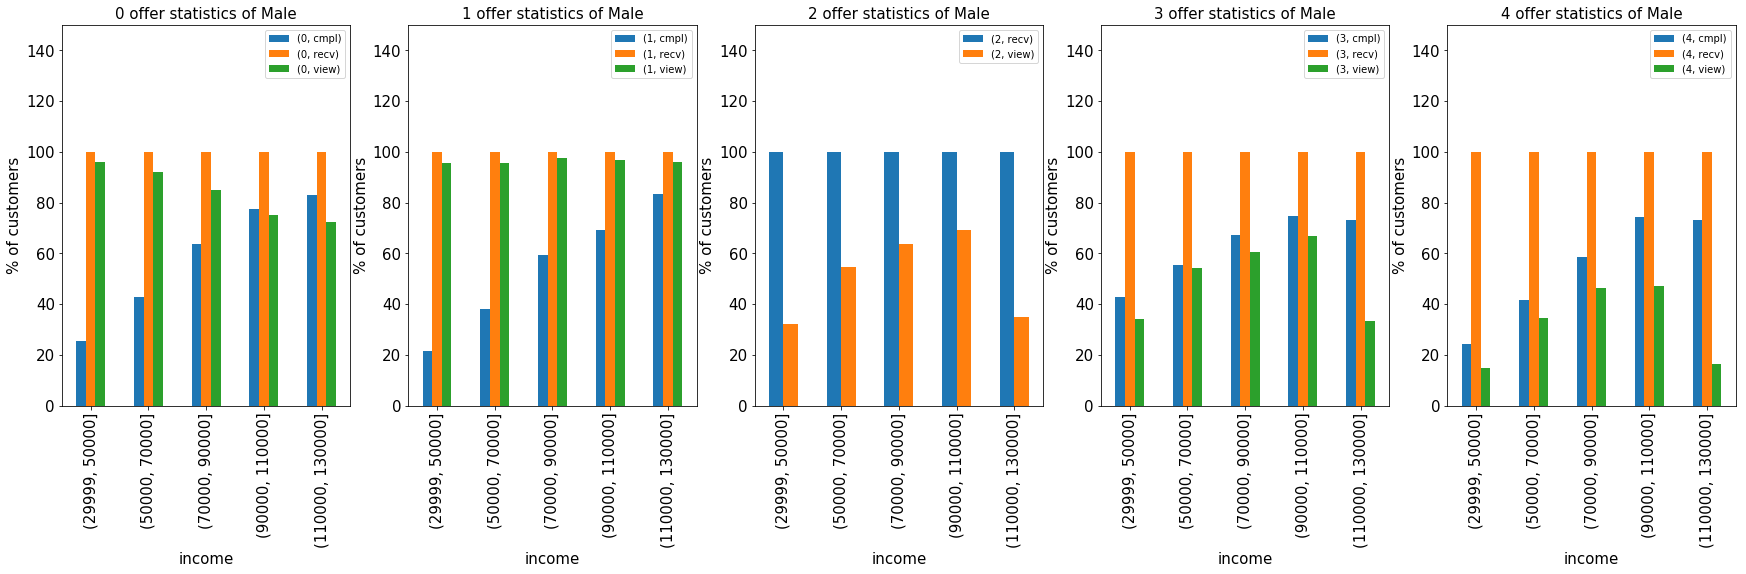

In [87]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i)+' offer statistics of Male',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i,['income'],'M').plot.bar(rot=90,ax=ax)


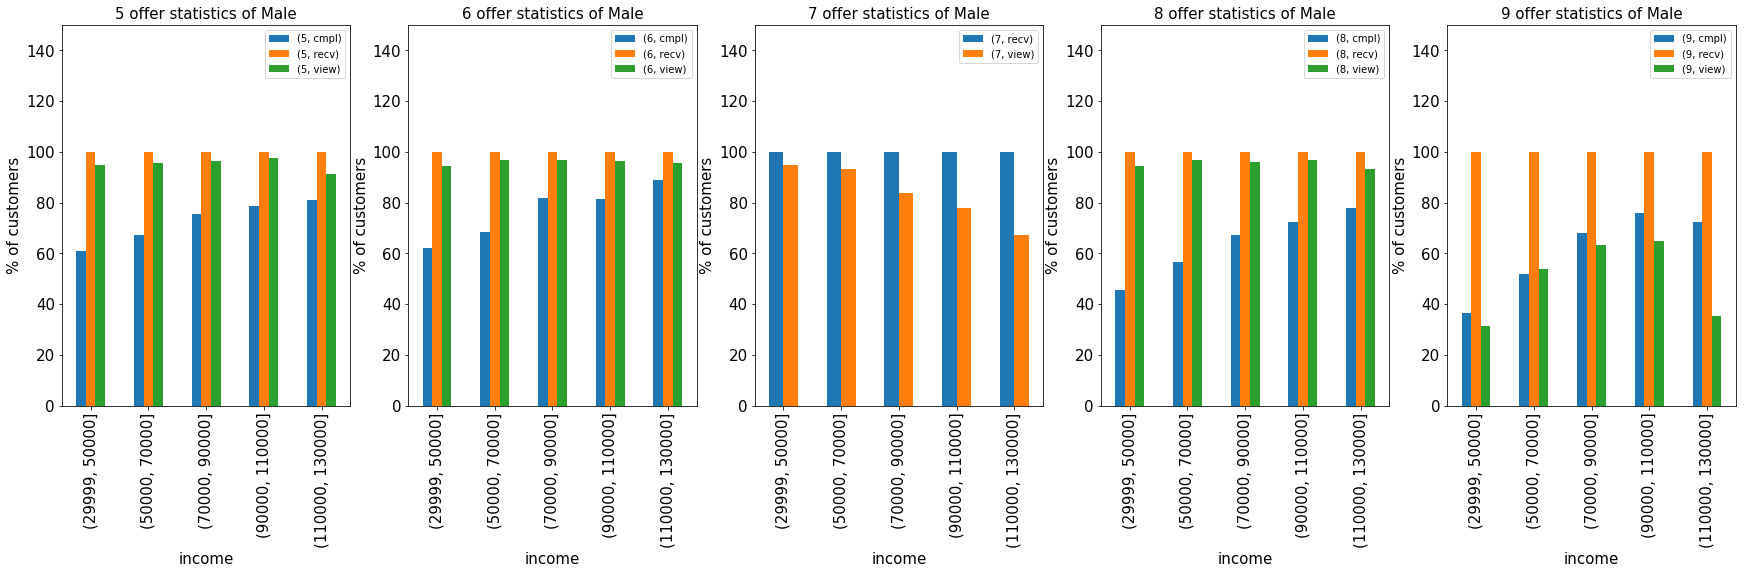

In [88]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i+5)+' offer statistics of Male',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i+5,['income'],'M').plot.bar(rot=90,ax=ax)


In [89]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
